In [2]:
import pvdeg.stressor
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import numpy as np
import pvlib
import seaborn as sns

### sequence support might look something like this

Using preset sequences we could do the following. Or these could refer to variables in the pvdeg namespace.  
`sequence=['wet_hot', 'wet_hot', 'dry_hot', 'cold_superwet']`  

This would just be one loop but because of convieneny python syntax we could do the following to repeat the sequence twice.  `sequence * 2`

In [3]:
points = pvdeg.stressor.chamber_setpoints(
    fp = 'chamber-setpoints.csv',
    t_0=25,
    rh_0=50,
    irrad_0=0,
    v_0=0,
    )

points = pvdeg.stressor.repeat(points, 3)

<Axes: title={'center': 'chamber setpoints'}>

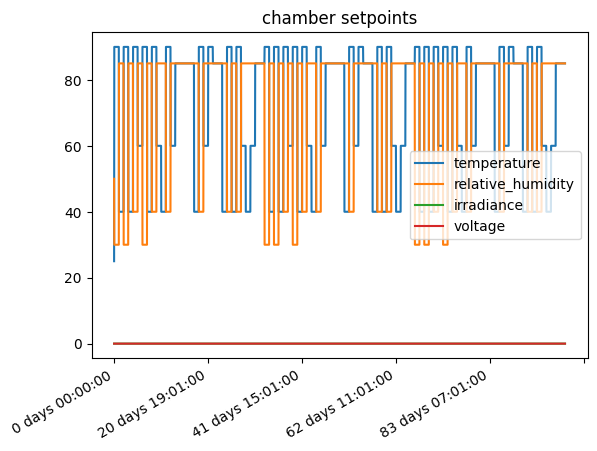

In [4]:
points.plot(title='chamber setpoints')

In [5]:
points

,temperature,relative_humidity,irradiance,voltage
0 days 00:00:00,25,50,0,0
0 days 00:01:00,90,30,0,0
0 days 01:01:00,90,30,0,0
0 days 02:01:00,90,30,0,0
0 days 03:01:00,90,30,0,0
...,...,...,...,...
99 days 19:01:00,85,85,0,0
99 days 20:01:00,85,85,0,0
99 days 21:01:00,85,85,0,0
99 days 22:01:00,85,85,0,0


In [6]:
props = pvdeg.stressor.chamber_properties(
    set_point_df=points, 
    tau=10, 
    chamber_irrad_0=0, 
    sample_temp_0=25,
    eva_solubility=0.17337995,
    solubility_prefactor=1.81390702,
    pet_permiability=0.553059381,
    pet_prefactor=674449898.1,
    thickness_eva=0.4572,
    thickness_pet=0.1016,
    )

In [7]:
props

,water_vapor_pressure,dew_point,sample_temperature,rh_at_sample_temp,equilibrium_eva_water,backsheet_moisture,rh_internal_backside_cells
0 days 00:00:00,1.586603,13.799419,25,49,0.001043,0.001043,49.000000
0 days 00:01:00,21.050473,61.168821,31,462,0.011229,0.002646,108.861922
0 days 01:01:00,21.050473,61.168821,89,31,0.002174,0.002250,32.096626
0 days 02:01:00,21.050473,61.168821,89,31,0.002174,0.002186,31.178509
0 days 03:01:00,21.050473,61.168821,89,31,0.002174,0.002176,31.029058
...,...,...,...,...,...,...,...
99 days 19:01:00,49.353716,81.111387,84,88,0.005708,0.005708,88.000000
99 days 20:01:00,49.353716,81.111387,84,88,0.005708,0.005708,88.000000
99 days 21:01:00,49.353716,81.111387,84,88,0.005708,0.005708,88.000000
99 days 22:01:00,49.353716,81.111387,84,88,0.005708,0.005708,88.000000


## checking things

Good
- water vapor $P$
- dew point
- set points
- sample temperature is functional and matches spreadsheet for test cases

Still questionable 
- backsheet_moisture	

Text(0.5, 1.0, 'Sample Temperatures (WRONG), black line should be correct maximum')

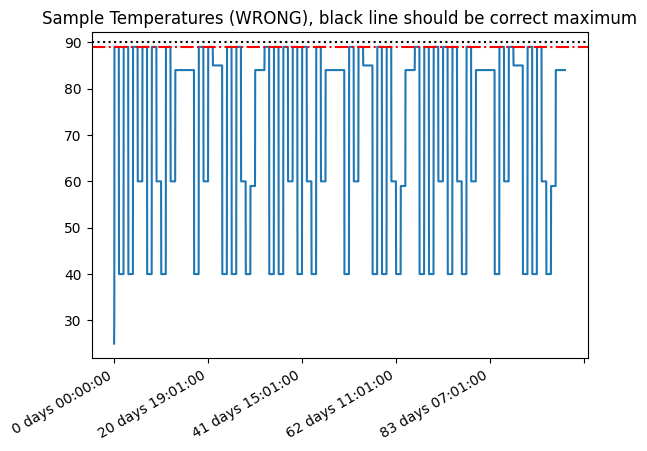

In [8]:
props['sample_temperature'].plot() # should have a max of 90
plt.axhline(props['sample_temperature'].max(), c='r', linestyle='-.' )
plt.axhline(y=90, c='black', linestyle=':')
plt.title('Sample Temperatures (WRONG), black line should be correct maximum')

### Changing Tau

$\tau$ characteristic thermal equilibration time. Because our timescale is relatively small

$\tau = RC$ where R is the thermal resistance from the object to the surroundings and C is the objects thermal capacitance. This gives us a general sense of the time scale


### Changing Tau Timescale (IS THIS VALID???)

Say we know  $\tau = 10$ at a timescale where eachstep represents a change of, $\Delta T = 58.3$ minutes. Isolating $\tau$ in the finite differenence temperature model used in the `pvdeg.temperature.chamber_sample_temperature` yields the following,  
$\tau = \frac{-\Delta t}{\ln{\frac{T_2 - T_0}{T_1 - T_0}}}$

This shows that $\tau$ has a linear relationship with $\Delta T$ so we can simply convert by dividing $\tau_{new} = \tau_{old} / \Delta t_{old} * \Delta t_{new}$



In [9]:
props = pvdeg.stressor.chamber_properties(
    set_point_df=points, 
    tau=10 / 58.33471892 * 1, # new tau calculated using equation above
    chamber_irrad_0=0, 
    sample_temp_0=25,
    eva_solubility=0.17337995,
    solubility_prefactor=1.81390702,
    pet_permiability=0.553059381,
    pet_prefactor=674449898.1,
    thickness_eva=0.4572,
    thickness_pet=0.1016,
    )

### DataFrame formatted same as excel

In [10]:
comb = pd.concat([points, props], axis=1)
comb

,temperature,relative_humidity,irradiance,voltage,water_vapor_pressure,dew_point,sample_temperature,rh_at_sample_temp,equilibrium_eva_water,backsheet_moisture,rh_internal_backside_cells
0 days 00:00:00,25,50,0,0,1.586603,13.799419,25,49,0.001043,0.001043,49.000000
0 days 00:01:00,90,30,0,0,21.050473,61.168821,89,31,0.002174,0.001989,28.374131
0 days 01:01:00,90,30,0,0,21.050473,61.168821,90,29,0.002065,0.002053,28.838798
0 days 02:01:00,90,30,0,0,21.050473,61.168821,90,29,0.002065,0.002063,28.975407
0 days 03:01:00,90,30,0,0,21.050473,61.168821,90,29,0.002065,0.002064,28.996248
...,...,...,...,...,...,...,...,...,...,...,...
99 days 19:01:00,85,85,0,0,49.353716,81.111387,85,85,0.005601,0.005601,85.000000
99 days 20:01:00,85,85,0,0,49.353716,81.111387,85,85,0.005601,0.005601,85.000000
99 days 21:01:00,85,85,0,0,49.353716,81.111387,85,85,0.005601,0.005601,85.000000
99 days 22:01:00,85,85,0,0,49.353716,81.111387,85,85,0.005601,0.005601,85.000000


In [ ]:
def module_front_center_equilibrated(
        # there are extras here because we these are just the dims straight from the macro
        TempColumn: int,
        RHColumn: int,
        X, Y, z, XX, YY, ZZ, Q, # ints, we will git rid of these probably
        StartRow: int, 
        OutCol: int,
        CurRow: int,
        CurrentYear: float,
        OutRow: float,
        Xout: float, # first output distance from the edge
        Nout: float, # first of two outputs nodes for linear interpolation

        set_points: pd.DataFrame,
        chamber_proportions: pd.DataFrame,        
        diffusivity_eva: float, # eV
        diffusivity_prefactor: float, # cm^2/s

        P: float = 0.1, # perimiter area width in cm
        CW: float = 15.6, # cell dimesions in cm. total simulated square is CW + 2P wide
        n_steps: float = 10, # NT (substeps), # This is the number of steps to further break down the time steps.'
        NY: float = 7, # 11 This is the number of years to do the calculation. It will only store the last year of data'
        NSkip: float = 1, # 365  This is the number of hours or time steps to skip before an output point is displayed # this doesnt work because we are in minutes'
        n: int = 50, # number of nodes
) -> np.ndarray[float]:
   """Calculate the profile of the water in front of the cells on a polymer back module"""

   Water = np.ndarray(n, n) # vba is 1 indexed so this might get weird
   WaterNew = np.empty_like(Water) # this should maybe be 0s like
   EaD = diffusivity_eva / 0.0000861733241 # The activation energy for eva diffusivity in electron volts and k is 8.61733241*10^-5 eV/K.  
   
   W = ((CW + 2 * P) / 2) / n # This is the width of FE units in a quadrant of the backside of a cell assuming a 1mm distance perimeter to reach the back side of the cell.

   timedeltas = points.index.values
   time_step = timedeltas[2] - timedeltas[1]
   time_step_sec = time_step.astype('timedelta64[s]').astype(np.int32) # should already be timedelta64[s]

   water = np.zeros((20,20))
   water_new = np.zeros_like(water)


   for i in range(comb.shape[0]-1):
      Temperature = comb['sample_temperature'].values[i]
      DTemperature = (comb['sample_temperature'].values[i+1] - comb['sample_temperature'].values[i]) / n_steps
      Disolved = comb['backsheet_moisture'].values[i]
      DDisolved = (comb['backsheet_moisture'].values[i+1] - comb['backsheet_moisture'].values[i]) / n_steps

      Fo = Dif * np.exp(-EaD / (273.15 + Temperature)) * T / (W * W) # this is the same per substep
      print(Fo) # above the bound
      
      @njit
      def calc_substeps(water, water_new, Temperature, DTemperature, Disolved, DDisolved, Fo, n_steps)->np.ndarray:
         for i in range(n_steps):
               water[0,:] = Disolved # intial state

               # water_new = np.copy(water) # create a deep copy of the 2d array
               water_new[:,:] = water
               water_new[-1,-1] = Fo * (water[-2,-1] * 4) + (1 - 4 * Fo) * water[-1,-1] # inner point

               for y in range(1, water.shape[0] - 1):
                  for x in range(y+1, water.shape[1] - 1):
                     if x > y: # central nodes, rightwards of the diagonal
                           water_new[y,x] = Fo * (water[y, x+1] + water[y, x-1] + water[y+1, x] + water[y-1, x]) + (1 - 4 * Fo) * water[y, x] # central nodes
                  
                  water_new[y,y] = Fo * (2 * water[y, y-1] + 2 * water[y+1, y]) + (1 - 4 * Fo) * water[y, y] # diagonal nodes

                  # now we care about the inner side
                  water_new[y, -1] = Fo * (water[y+1,-1] + water[y-1,n] + 2 * water[y,n-1]) + (1 - 4 * Fo) * water[y,-1]

               Temperature += DTemperature
               Disolved += DDisolved
               water[:,:] = water_new

         return water
      
      water = calc_substeps(water, water_new, Temperature, DTemperature, Disolved, DDisolved, Fo, n_steps) # update the water values


In [21]:
from numba import njit

# equilibrated 
# def module_front_center_equilibrated(

n_steps = 20 # number of substeps
Dif = 2.310978817 # prefactor not activation energy
EaD = 2.7 / 0.0000861733241
times = props.index.values
T = (times[1] - times[0]).astype('timedelta64[s]').astype(int) # first number of seconds
P = 0.1 # 
CW = 15.6 # 
n = 20 # number of nodes in to use for the 2d solution
W = ((CW + 2 * P) / 2) / n # This is the width of FE units in a quadrant of the backside of a cell assuming a 1mm distance perimeter to reach the back side of the cell.

water = np.zeros((20,20)) # define arrays outside of loops so we can update them
water_new = np.zeros_like(water)

# we will do all the substeps
for i in range(comb.shape[0]-1):
    Temperature = comb['sample_temperature'].values[i]
    DTemperature = (comb['sample_temperature'].values[i+1] - comb['sample_temperature'].values[i]) / n_steps
    Disolved = comb['backsheet_moisture'].values[i]
    DDisolved = (comb['backsheet_moisture'].values[i+1] - comb['backsheet_moisture'].values[i]) / n_steps

    # if we are on the first iteration
    if i == 1:
        T = (times[2] - times[1]).astype('timedelta64[s]').astype(int) # number of seconds in step period, should be the same after this

    Fo = Dif * np.exp(-EaD / (273.15 + Temperature)) * T / (W * W) # this is the same per substep
    print(Fo, T) # check Fo
    
    # WHY IS THIS 5X SLOWER WITH NUMBA
    def calc_substeps(water, water_new, Temperature, DTemperature, Disolved, DDisolved, Fo, n_steps)->np.ndarray:
        for i in range(n_steps):
            water[0,:] = Disolved # intial state

            water_new[:,:] = water # create a copy of the array
            water_new[-1,-1] = Fo * (water[-2,-1] * 4) + (1 - 4 * Fo) * water[-1,-1] # inner point

            for y in range(1, water.shape[0] - 1): # iterate rows in array
                for x in range(y+1, water.shape[1] - 1): # iterate columns in row
                    # this part could be swapped to a convolution without loops using a cross pattern 
                    # 0 1 0
                    # 1 0 1
                    # 0 1 0
                    surroundings =  np.array([
                        water[y-1,x], 
                        water[y+1,x],
                        water[y,x-1],
                        water[y,x+1]
                        ])

                    water_new[y, x] = Fo * np.sum(surroundings) + (1 - 4 * Fo) * water[y, x]
               
                water_new[y,y] = Fo * (2 * water[y-1, y] + 2 * water[y, y+1]) + (1 - 4 * Fo) * water[y, y] # diagonal nodes

                water_new[y, -1] = Fo * (water[y+1,-1] + water[y-1,-1] + 2 * water[y,-2]) + (1 - 4 * Fo) * water[y,-1] # internal edge (right side), kempe called these bottom nodes in the spreadsheet

            Temperature += DTemperature
            Disolved += DDisolved
            # water[:,:] = water_new

        # return water
        return water_new
    
    water = calc_substeps(water, water_new, Temperature, DTemperature, Disolved, DDisolved, Fo, n_steps) # update the water values

2.0384571495132455e-43 60


TypeError: unhashable type: 'numpy.ndarray'

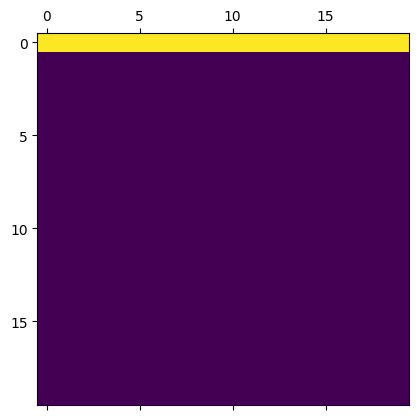

In [19]:
plt.matshow(water)

In [20]:
water[1]

array([0.00000000e+00, 2.31498451e-31, 1.15749225e-31, 1.15749225e-31,
       1.15749225e-31, 1.15749225e-31, 1.15749225e-31, 1.15749225e-31,
       1.15749225e-31, 1.15749225e-31, 1.15749225e-31, 1.15749225e-31,
       1.15749225e-31, 1.15749225e-31, 1.15749225e-31, 1.15749225e-31,
       1.15749225e-31, 1.15749225e-31, 1.15749225e-31, 1.15749225e-31])